In [1]:
# This cell is not visible when the documentation is built.

import numpy as np
import xarray as xr

# Create 'toy' criteria selection data
np.random.normal(loc=3.5, scale=1.5, size=50)
#crit['delta_annual_tavg']
np.random.seed(0)
test = xr.DataArray(np.random.normal(loc=3, scale=1.5, size=50), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=5.34, scale=2, size=50), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')

ds_crit = xr.Dataset()

ds_crit['delta_annual_tavg'] = test
test = xr.DataArray(np.random.normal(loc=5, scale=5, size=50), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=10, scale=8, size=50), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit['delta_annual_prtot'] = test
test = xr.DataArray(np.random.normal(loc=0, scale=3, size=50), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=2, scale=4, size=50), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit['delta_JJA_prtot'] = test

Ensemble -  Reduction Techniques
=============================

`xclim.ensembles` provides means of reducing the number of candidates in a sample to get a reasonable and representative spread of outcomes using a reduced number of candidates. By reducing the number of realizations in a strategic manner, we can significantly reduce the number of realizations to examine, while maintaining statistical representation of original dataset. This is particularly useful when computation power or time is a factor.

For more information on the principles and methods behind ensmeble reduction techniques, see: https://doi.org/10.1175/JCLI-D-14-00636.1

**Selection Criteria**
The following example considers 50 members in a cluster with a total of 6 criteria considered (3 variable deltas * 2 time horizons). Our goal is to reduce this number to a more manageable size while preserving the the range of uncertainty across our criteria.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xclim import ensembles

# Using an xarray dataset of our criteria
ds_crit: xr.Dataset
ds_crit

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 50)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 5.646 3.6 ... 5.594 6.144
    delta_annual_prtot  (horizon, realization) float64 14.42 -1.739 ... 20.69
    delta_JJA_prtot     (horizon, realization) float64 -1.108 -0.7181 ... 3.48

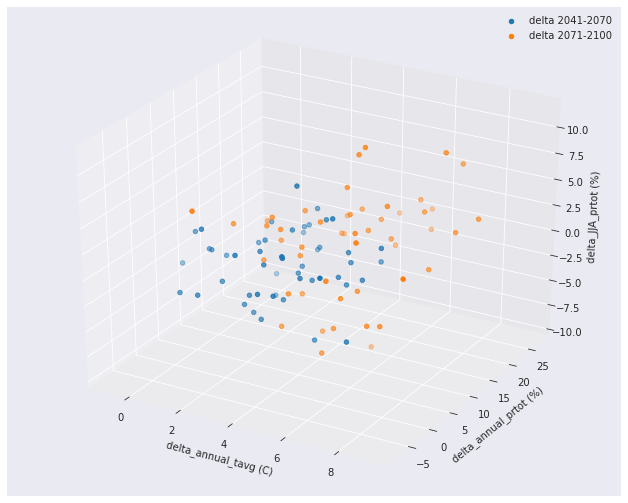

In [27]:
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (13, 5)
fig = plt.figure(figsize=(11,9))
ax = plt.axes(projection='3d')

for h in ds_crit.horizon:
    ax.scatter(ds_crit.sel(horizon=h).delta_annual_tavg, ds_crit.sel(horizon=h).delta_annual_prtot,
            ds_crit.sel(horizon=h).delta_JJA_prtot,label=f"delta {h.values}")

ax.set_xlabel('delta_annual_tavg (C)')
ax.set_ylabel('delta_annual_prtot (%)')
ax.set_zlabel('delta_JJA_prtot (%)')
plt.legend()
plt.show()

Ensemble reduction techniques in `xclim` require a 2D array with dimensions of `criteria` (values) and `realization` (runs/simulations).

In [28]:
# Create 2d xr.DataArray containincg criteria values
crit=None
for h in ds_crit.horizon:
    for v in ds_crit.data_vars:
        if crit is None:
            crit = ds_crit[v].sel(horizon=h)
        else:
            crit = xr.concat((crit, ds_crit[v].sel(horizon=h)), dim='criteria')
crit.name= 'criteria'
crit.shape

(6, 50)

#### **K-Means reduce ensemble**

The `kmeans_reduce_ensemble` works by grouping realizations into sub-groups based on the provided critera and retaining a representative `realization` per sub-group.

For a real-world example of the K-means clustering algorithm applied to climate data selection, see: https://doi.org/10.1175/JCLI-D-11-00440.1

The following example uses `method = dict(n_clusters=25)` in order to take the original `50` realizations and reduce them down to `25`. The function itself returns the `ids` (indexes: `int`) of the realizations, which can then be used to select the data from the original ensemble.

In [5]:
ids, cluster, fig_data = ensembles.kmeans_reduce_ensemble(data=crit, method={'n_clusters':25}, random_state=42, make_graph=True)
ds_crit.isel(realization = ids)

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 25)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 3.6 4.468 ... 7.293 8.912
    delta_annual_prtot  (horizon, realization) float64 -1.739 -1.352 ... 16.59
    delta_JJA_prtot     (horizon, realization) float64 -0.7181 3.299 ... 4.332

With this reduced number, we can now compare the distribution of the selection versus the original ensemble of simulations.

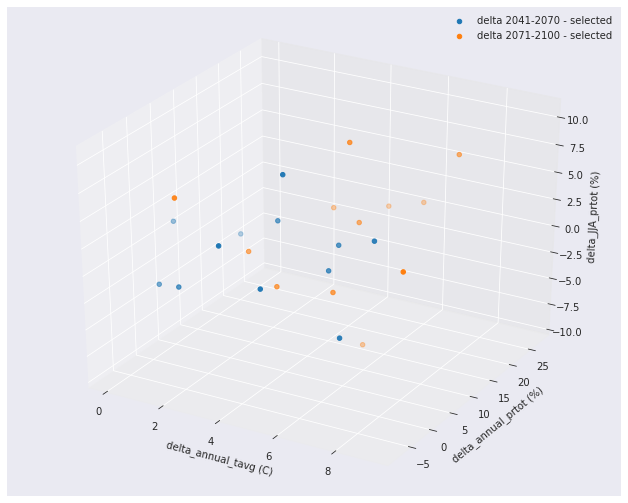

In [29]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(11,9))
ax = plt.axes(projection='3d')

for h in ds_crit.horizon:
    ax.scatter(ds_crit.sel(horizon=h,realization=ids).delta_annual_tavg, ds_crit.sel(horizon=h, realization=ids).delta_annual_prtot ,
            ds_crit.sel(horizon=h,realization=ids).delta_JJA_prtot,label=f"delta {h.values} - selected")

ax.set_xlabel('delta_annual_tavg (C)')
ax.set_ylabel('delta_annual_prtot (%)')
ax.set_zlabel('delta_JJA_prtot (%)')
plt.legend()
plt.show()

The function optionally produces a data dictionary for figure production of the associated R² profile.

The function`ensembles.plot_rsqprofile` provides plotting for evaluating the proportion of total variance in climate realizations that is covered by the selection.

In this case ~78% of the total variance in original ensemble is covered by the selection.

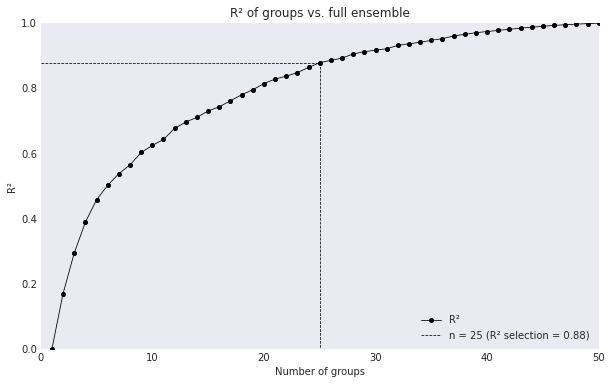

In [7]:
ensembles.plot_rsqprofile(fig_data)

Alternatively we can use `method = {'rsq_cutoff':Float}` or `method = {'rsq_optimize':None}`
* For example with `rsq_cutoff` we instead find the number of realizations needed to cover the provided $R^{2}$ value

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 24)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 3.6 4.468 ... 7.293 8.912
    delta_annual_prtot  (horizon, realization) float64 -1.739 -1.352 ... 16.59
    delta_JJA_prtot     (horizon, realization) float64 -0.7181 3.299 ... 4.332

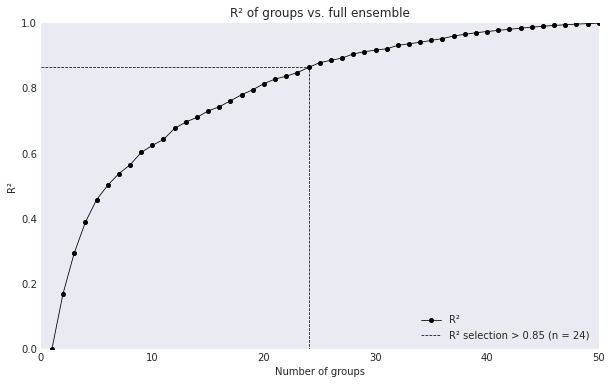

In [8]:
ids1, cluster1, fig_data1 = ensembles.kmeans_reduce_ensemble(data=crit, method={'rsq_cutoff':0.85}, random_state=42, make_graph=True)
ensembles.plot_rsqprofile(fig_data1)
ds_crit.isel(realization=ids1)

#### **KKZ reduce ensemble**

`xclim` also makes available a similar ensemble reduction algorithm, `ensembles.kkz_reduce_ensemble`. The adavntage of this algorithm is largely that fewer realizations are needed in order to reach the same level of representative members than the K-means clustering algorithm, as the KKZ methods tends towards identifying members that fall towards the extremes of criteria values.

In [33]:
ids = ensembles.kkz_reduce_ensemble(crit, num_select=10)
ds_crit.isel(realization=ids)

<xarray.Dataset>
Dimensions:             (horizon: 2, realization: 10)
Coordinates:
  * horizon             (horizon) object '2041-2070' '2071-2100'
Dimensions without coordinates: realization
Data variables:
    delta_annual_tavg   (horizon, realization) float64 1.719 6.405 ... 7.449
    delta_annual_prtot  (horizon, realization) float64 9.611 1.527 ... 22.34
    delta_JJA_prtot     (horizon, realization) float64 -0.1268 -4.622 ... 7.207

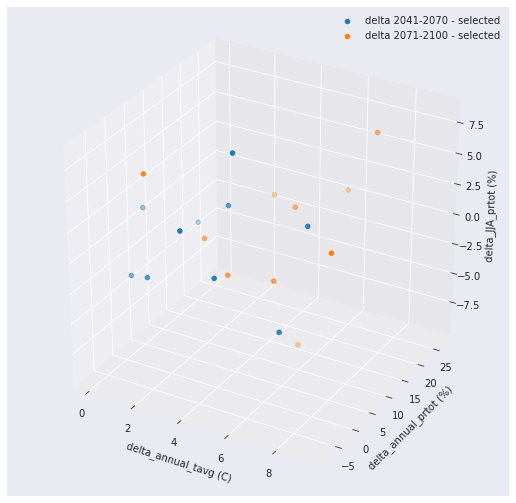

In [34]:
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')

for h in ds_crit.horizon:

    ax.scatter(ds_crit.sel(horizon=h,realization=ids).delta_annual_tavg, ds_crit.sel(horizon=h, realization=ids).delta_annual_prtot ,
            ds_crit.sel(horizon=h,realization=ids).delta_JJA_prtot,label=f"delta {h.values} - selected")

ax.set_xlabel('delta_annual_tavg (C)')
ax.set_ylabel('delta_annual_prtot (%)')
ax.set_zlabel('delta_JJA_prtot (%)')
plt.legend()
plt.show()

To give a better sense of the differences between **Nested** and **Unnested** results, we can progressively identify members that would be chosen by each algorithm by iterative fashion.

In [35]:
## NESTED results using KKZ
for n in np.arange(5, 13):
    ids = ensembles.kkz_reduce_ensemble(crit, num_select=n)
    print(ids)
    

[19, 24, 33, 3, 21]
[19, 24, 33, 3, 21, 18]
[19, 24, 33, 3, 21, 18, 35]
[19, 24, 33, 3, 21, 18, 35, 48]
[19, 24, 33, 3, 21, 18, 35, 48, 40]
[19, 24, 33, 3, 21, 18, 35, 48, 40, 39]
[19, 24, 33, 3, 21, 18, 35, 48, 40, 39, 29]
[19, 24, 33, 3, 21, 18, 35, 48, 40, 39, 29, 11]


In [17]:
## UNNESTED results using k-means
for n in np.arange(5, 13):
    ids, cluster, fig_data = ensembles.kmeans_reduce_ensemble(crit, method={'n_clusters':n}, random_state=42, make_graph=True)
    print(ids)

[7, 12, 27, 35, 45]
[7, 12, 27, 36, 45, 49]
[12, 14, 26, 27, 34, 35, 45]
[12, 14, 19, 26, 27, 35, 45, 49]
[12, 14, 19, 27, 29, 32, 33, 35, 49]
[2, 12, 14, 19, 27, 29, 33, 35, 40, 49]
[2, 6, 14, 16, 27, 32, 33, 35, 45, 46, 49]
[0, 2, 5, 7, 10, 12, 19, 29, 35, 38, 43, 49]
